# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2"))

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython.display import Image, display

from libs.isic import load
from libs.fractal_percolation_module import FractalModule
from libs.auc import calculate_auc
from libs.gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [3]:
tf.get_logger().setLevel('ERROR')

## Hyperparameter definition

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
with strategy.scope():
    EPOCHS = 200
    SAMPLE_NUMBER = None
    
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    FRACTAL_WIDTH, FRACTAL_HEIGHT = 10, 10
    FRACTAL_MODULE = FractalModule(FRACTAL_WIDTH, FRACTAL_HEIGHT)
    O_MODEL = tf.keras.applications.mobilenet_v2.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    F_MODEL = tf.keras.applications.mobilenet_v2.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    RETRAINABLE_LAYERS = ['lock_16_project', 'block_16_project_BN']
    LAST_LAYER = 'block_16_project_BN'
    PREPROCESSING = tf.keras.applications.mobilenet_v2.preprocess_input

## Load the ISIC Archive dataset

In [6]:
(training_set, validation_set, testing_set), class_weights, class_number = load(SAMPLE_NUMBER)

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2/libs/isic/load.py:8: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


## Model definition

In [7]:
class LesionClassifier(tf.keras.Model):
    def __init__(self):
        super(LesionClassifier, self).__init__()
        
        self.fractal_module = FRACTAL_MODULE
        
        self.resize = tf.keras.layers.Resizing(
            width=TARGET_WIDTH,
            height=TARGET_HEIGHT
        )
        
        self.rescale = tf.keras.layers.Rescaling(scale=1. / 255)
        
        self.o_model = O_MODEL
        for layer in self.o_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.f_model = F_MODEL
        for layer in self.f_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.fusion = tf.keras.layers.Concatenate()
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        f_outputs = self.fractal_module(inputs)
        f_outputs = self.resize(f_outputs)
        f_outputs = self.rescale(f_outputs)
        f_outputs = self.f_model(f_outputs)

        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)

        outputs = self.fusion([f_outputs, o_outputs])
        outputs = self.dense(outputs)

        return outputs

In [8]:
checkpoint_path = 'checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=15, 
    restore_best_weights=True
)

In [10]:
time_stopping = tfa.callbacks.TimeStopping(seconds=65 * 3600)

## Training

In [11]:
with strategy.scope():
    model = LesionClassifier()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=EPOCHS,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        time_stopping
    ]
)

Epoch 1/200
947/947 [==============================] - ETA: 0s - loss: 0.8251 - accuracy: 0.7284

947/947 [==============================] - 3692s 4s/step - loss: 0.8251 - accuracy: 0.7284 - val_loss: 4.9062 - val_accuracy: 0.6755
Epoch 2/200
947/947 [==============================] - 3279s 3s/step - loss: 0.7241 - accuracy: 0.7525 - val_loss: 9.4813 - val_accuracy: 0.6646
Epoch 3/200
947/947 [==============================] - ETA: 0s - loss: 0.6675 - accuracy: 0.7700

947/947 [==============================] - 3472s 4s/step - loss: 0.6675 - accuracy: 0.7700 - val_loss: 2.8477 - val_accuracy: 0.5216
Epoch 4/200
947/947 [==============================] - 3269s 3s/step - loss: 0.6361 - accuracy: 0.7787 - val_loss: 3.9787 - val_accuracy: 0.6650
Epoch 5/200
947/947 [==============================] - ETA: 0s - loss: 0.6118 - accuracy: 0.7866

947/947 [==============================] - 3453s 4s/step - loss: 0.6118 - accuracy: 0.7866 - val_loss: 2.0208 - val_accuracy: 0.6222
Epoch 6/200
947/947 [==============================] - ETA: 0s - loss: 0.5965 - accuracy: 0.7948

947/947 [==============================] - 3480s 4s/step - loss: 0.5965 - accuracy: 0.7948 - val_loss: 1.1113 - val_accuracy: 0.6550
Epoch 7/200
947/947 [==============================] - 3258s 3s/step - loss: 0.5723 - accuracy: 0.7969 - val_loss: 1.3938 - val_accuracy: 0.6751
Epoch 8/200
947/947 [==============================] - 3261s 3s/step - loss: 0.5624 - accuracy: 0.8023 - val_loss: 1.9550 - val_accuracy: 0.5640
Epoch 9/200
947/947 [==============================] - ETA: 0s - loss: 0.5475 - accuracy: 0.8079

947/947 [==============================] - 3470s 4s/step - loss: 0.5475 - accuracy: 0.8079 - val_loss: 0.9352 - val_accuracy: 0.7419
Epoch 10/200
947/947 [==============================] - 3248s 3s/step - loss: 0.5342 - accuracy: 0.8095 - val_loss: 0.9573 - val_accuracy: 0.7623
Epoch 11/200
947/947 [==============================] - 3261s 3s/step - loss: 0.5227 - accuracy: 0.8131 - val_loss: 1.5132 - val_accuracy: 0.5728
Epoch 12/200
947/947 [==============================] - 3252s 3s/step - loss: 0.5130 - accuracy: 0.8180 - val_loss: 1.1959 - val_accuracy: 0.6488
Epoch 13/200
947/947 [==============================] - 3248s 3s/step - loss: 0.5036 - accuracy: 0.8211 - val_loss: 0.9667 - val_accuracy: 0.7444
Epoch 14/200
947/947 [==============================] - 3248s 3s/step - loss: 0.4943 - accuracy: 0.8244 - val_loss: 1.0842 - val_accuracy: 0.7053
Epoch 15/200
947/947 [==============================] - ETA: 0s - loss: 0.4882 - accuracy: 0.8277

947/947 [==============================] - 3441s 4s/step - loss: 0.4882 - accuracy: 0.8277 - val_loss: 0.7966 - val_accuracy: 0.7517
Epoch 16/200
947/947 [==============================] - ETA: 0s - loss: 0.4752 - accuracy: 0.8301

947/947 [==============================] - 3450s 4s/step - loss: 0.4752 - accuracy: 0.8301 - val_loss: 0.6691 - val_accuracy: 0.7922
Epoch 17/200
947/947 [==============================] - 3249s 3s/step - loss: 0.4705 - accuracy: 0.8325 - val_loss: 0.8537 - val_accuracy: 0.7485
Epoch 18/200
947/947 [==============================] - 3246s 3s/step - loss: 0.4620 - accuracy: 0.8361 - val_loss: 0.7681 - val_accuracy: 0.7799
Epoch 19/200
947/947 [==============================] - 3240s 3s/step - loss: 0.4578 - accuracy: 0.8350 - val_loss: 0.9268 - val_accuracy: 0.7185
Epoch 20/200
947/947 [==============================] - ETA: 0s - loss: 0.4486 - accuracy: 0.8389

947/947 [==============================] - 3429s 4s/step - loss: 0.4486 - accuracy: 0.8389 - val_loss: 0.6666 - val_accuracy: 0.7895
Epoch 21/200
947/947 [==============================] - 3247s 3s/step - loss: 0.4422 - accuracy: 0.8407 - val_loss: 0.7900 - val_accuracy: 0.7794
Epoch 22/200
947/947 [==============================] - 3258s 3s/step - loss: 0.4327 - accuracy: 0.8431 - val_loss: 0.9821 - val_accuracy: 0.7611
Epoch 23/200
947/947 [==============================] - 3242s 3s/step - loss: 0.4280 - accuracy: 0.8469 - val_loss: 0.9002 - val_accuracy: 0.7629
Epoch 24/200
947/947 [==============================] - ETA: 0s - loss: 0.4209 - accuracy: 0.8495

947/947 [==============================] - 3452s 4s/step - loss: 0.4209 - accuracy: 0.8495 - val_loss: 0.6468 - val_accuracy: 0.7928
Epoch 25/200
947/947 [==============================] - 3239s 3s/step - loss: 0.4169 - accuracy: 0.8482 - val_loss: 0.8056 - val_accuracy: 0.7751
Epoch 26/200
947/947 [==============================] - 3256s 3s/step - loss: 0.4094 - accuracy: 0.8532 - val_loss: 0.6934 - val_accuracy: 0.7903
Epoch 27/200
947/947 [==============================] - 3241s 3s/step - loss: 0.4021 - accuracy: 0.8550 - val_loss: 0.6922 - val_accuracy: 0.7542
Epoch 28/200
947/947 [==============================] - 3237s 3s/step - loss: 0.3928 - accuracy: 0.8557 - val_loss: 0.6524 - val_accuracy: 0.8029
Epoch 29/200
947/947 [==============================] - ETA: 0s - loss: 0.3992 - accuracy: 0.8567

947/947 [==============================] - 3444s 4s/step - loss: 0.3992 - accuracy: 0.8567 - val_loss: 0.6326 - val_accuracy: 0.8093
Epoch 30/200
947/947 [==============================] - 3247s 3s/step - loss: 0.3919 - accuracy: 0.8572 - val_loss: 0.6550 - val_accuracy: 0.7979
Epoch 31/200
947/947 [==============================] - 3238s 3s/step - loss: 0.3823 - accuracy: 0.8612 - val_loss: 0.6539 - val_accuracy: 0.7957
Epoch 32/200
947/947 [==============================] - 3242s 3s/step - loss: 0.3798 - accuracy: 0.8627 - val_loss: 0.7615 - val_accuracy: 0.7855
Epoch 33/200
947/947 [==============================] - 3782s 4s/step - loss: 0.3717 - accuracy: 0.8640 - val_loss: 0.7436 - val_accuracy: 0.7687
Epoch 34/200
947/947 [==============================] - ETA: 0s - loss: 0.3662 - accuracy: 0.8684

947/947 [==============================] - 4044s 4s/step - loss: 0.3662 - accuracy: 0.8684 - val_loss: 0.5916 - val_accuracy: 0.8187
Epoch 35/200
947/947 [==============================] - 3697s 4s/step - loss: 0.3632 - accuracy: 0.8673 - val_loss: 0.6867 - val_accuracy: 0.7966
Epoch 36/200
947/947 [==============================] - ETA: 0s - loss: 0.3586 - accuracy: 0.8707

947/947 [==============================] - 3920s 4s/step - loss: 0.3586 - accuracy: 0.8707 - val_loss: 0.5416 - val_accuracy: 0.8181
Epoch 37/200
947/947 [==============================] - 3752s 4s/step - loss: 0.3536 - accuracy: 0.8720 - val_loss: 0.6073 - val_accuracy: 0.8024
Epoch 38/200
947/947 [==============================] - 3525s 4s/step - loss: 0.3560 - accuracy: 0.8682 - val_loss: 0.6184 - val_accuracy: 0.7998
Epoch 39/200
947/947 [==============================] - 3356s 4s/step - loss: 0.3408 - accuracy: 0.8775 - val_loss: 0.7945 - val_accuracy: 0.7667
Epoch 40/200
947/947 [==============================] - 3258s 3s/step - loss: 0.3399 - accuracy: 0.8754 - val_loss: 0.6057 - val_accuracy: 0.8015
Epoch 41/200
947/947 [==============================] - 3552s 4s/step - loss: 0.3366 - accuracy: 0.8773 - val_loss: 0.8914 - val_accuracy: 0.7823
Epoch 42/200
947/947 [==============================] - 4043s 4s/step - loss: 0.3328 - accuracy: 0.8793 - val_loss: 5.6504 - val_accuracy

## Testing

In [13]:
model.load_weights(checkpoint_path)

In [14]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [15]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 440s 3s/step


In [16]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [17]:
auc_metric

{'actinic keratosis': 0.9645501909695492,
 'basal cell carcinoma': 0.9795874674004411,
 'dermatofibroma': 0.9708722368526056,
 'melanoma': 0.9257837868363342,
 'nevus': 0.9589692335088146,
 'pigmented benign keratosis': 0.9850933471174897,
 'seborrheic keratosis': 0.9442217594094603,
 'solar lentigo': 0.9541238493959769,
 'squamous cell carcinoma': 0.9630890960656528,
 'vascular lesion': 0.998196472747586}

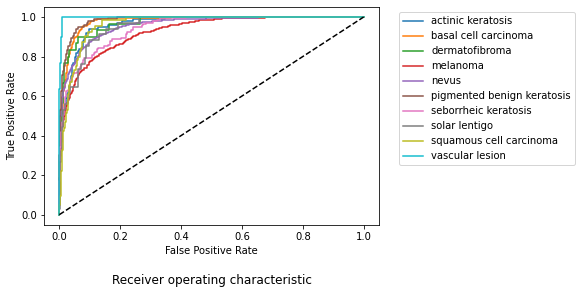

In [18]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

## GradCam

In [19]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

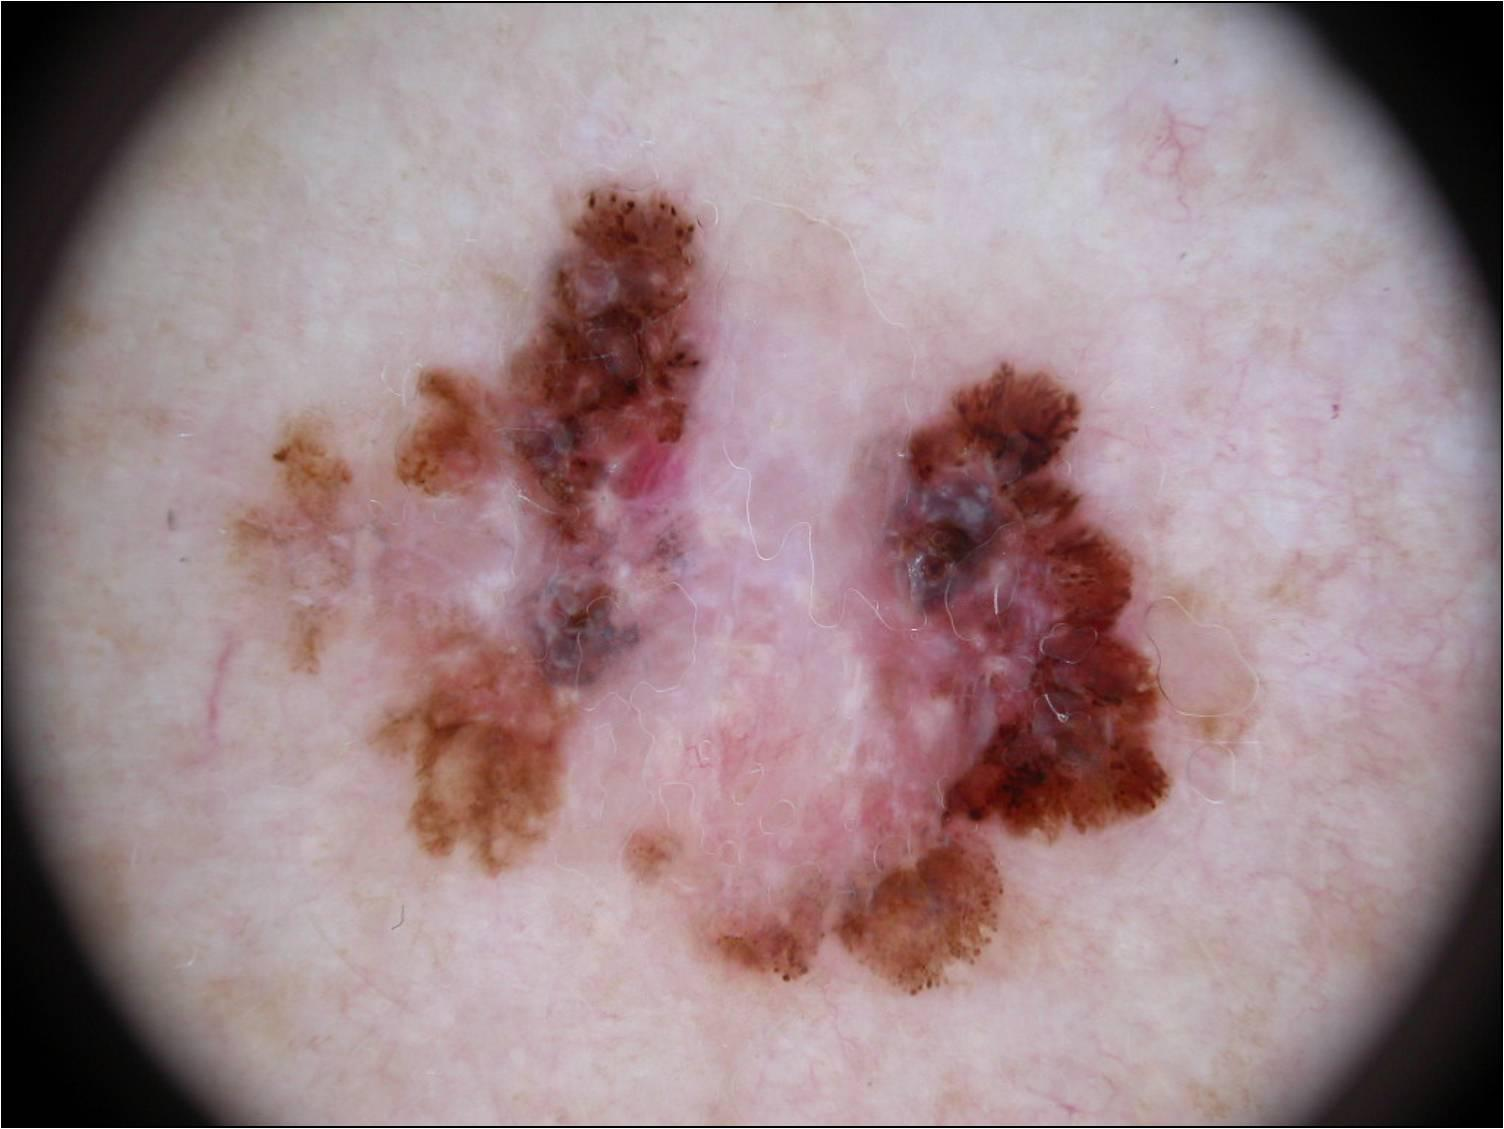

In [20]:
display(Image(melanoma_im_path, width=600))

In [21]:
img_array = PREPROCESSING(get_img_array(melanoma_im_path, size=(299, 299)))

In [22]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, LAST_LAYER)

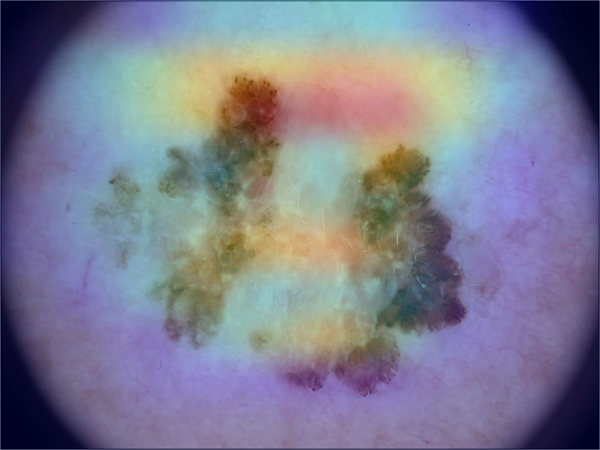

In [23]:
display_gradcam(melanoma_im_path, heatmap)